In [1]:
from pathlib import Path
import time
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

exec(open("../functions.py").read())

In [2]:
# set basic parameters and subdirectory
part_n = 500
e_part_r = 0.8
e_mean = 4
ei_std_s = [4, 4]
waiting_time = 300
interval_len = 900
freq = 0
subdirectory = ("{:n}_".format(part_n)
                + "{:n}_".format(e_part_r)
                + "{:n}_".format(e_mean)
                + "{0:n}-{1:n}/".format(ei_std_s[0],
                                        ei_std_s[1]))
#Path(subdirectory).mkdir()
print(ei_spectral_radius_fct(e_part_r, ei_std_s))

seed = 1695418797#round(time.time())
subdirectory = (subdirectory + "{:n}_".format(seed)
                + "{0:n}-{1:n}_".format(interval_len, 
                                        waiting_time)
                + "{:n}/".format(freq))
#Path(subdirectory).mkdir()
print(subdirectory)

4.0
500_0.8_4_4-4/1695418797_900-300_0/


In [3]:
# generate and save parameters for simulation
key = jax.random.PRNGKey(seed)

sub_part_r_s = jnp.asarray([e_part_r, 1 - e_part_r])
sub_part_n_s = sub_part_n_s_fct(part_n, sub_part_r_s)
unscaled_mean = ei_mean_balancer(sub_part_r_s, e_mean)
unscaled_std = jnp.tile(jnp.asarray([ei_std_s]), (2, 1))
connectivity_n = 5
in_r = 1.
rewiring_prob = 1.
[connectivity_s, key] = row_sum_removing_sparsifier(connectivity_s_generator(sub_part_n_s,
                                                                             unscaled_mean, unscaled_std,
                                                                             connectivity_n,
                                                                             key),
                                                    sub_part_n_s, in_r, rewiring_prob)
jnp.savez(subdirectory + "parameter_s_1.npz",
          sub_part_r_s, sub_part_n_s, unscaled_mean, unscaled_std,
          connectivity_n,
          in_r, rewiring_prob,
          connectivity_s)

sub_part_n_s_ext_gen = jnp.asarray([part_n])
ext_part_n = 1 #part_n // 100
ext_sub_part_r_s = jnp.asarray([1.])
ext_sub_part_n_s = sub_part_n_s_fct(ext_part_n, ext_sub_part_r_s)
unscaled_ext_mean = jnp.asarray([[0.]])
unscaled_ext_std = jnp.asarray([[1.]])
ext_connectivity_n = 4 * 4
unique_angle_n = jnp.floor(ext_connectivity_n / 2 + 1).astype(int)
[ext_connectivity_s, key] = ext_connectivity_s_generator(sub_part_n_s_ext_gen, ext_sub_part_n_s,
                                                         unscaled_ext_mean, unscaled_ext_std,
                                                         2,
                                                         key)
ext_connectivity_s = (ext_connectivity_s 
                      / jnp.std(ext_connectivity_s, axis = (1,2),keepdims=True)
                      / jnp.sqrt(ext_part_n))
angle_s = jnp.arange(ext_connectivity_n) * (2 * jnp.pi / ext_connectivity_n)
ext_connectivity_s = jnp.einsum("i,jk->ijk",
                                jnp.cos(angle_s), ext_connectivity_s[0]
                               ) + jnp.einsum("i,jk->ijk",
                                jnp.sin(angle_s), ext_connectivity_s[1])
jnp.savez(subdirectory + "parameter_s_2.npz",
          sub_part_n_s_ext_gen, 
          ext_part_n, ext_sub_part_r_s,
          ext_sub_part_n_s,
          unscaled_ext_mean, unscaled_ext_std, 
          ext_connectivity_n,
          angle_s, unique_angle_n,
          ext_connectivity_s)

phase_n = 2
[phase_s, key] = phase_s_generator(ext_part_n, phase_n, key)
jnp.savez(subdirectory + "parameter_s_3.npz",
          phase_n,
          phase_s)

amp_s = jnp.expand_dims(jnp.asarray([0.2, 0.5, 1., 8., 12.]), 
                        # or (wave_n, ext_part_n) array so different ext parts have different amps
                        1)
freq_s = jnp.full(amp_s.shape, freq)
wave_s = jnp.concatenate([amp_s, freq_s], axis = 1)
wave_n = wave_s.shape[0]
jnp.savez(subdirectory + "parameter_s_4.npz",
          amp_s, freq_s,
          wave_s,
          wave_n)

init_condition_n = 5
ext_condition_n = ext_connectivity_n * phase_n
init_condition_n_free = init_condition_n * ext_condition_n
[init_condition_s, key] = init_condition_s_generator(part_n, 
                                                           jnp.full((part_n, ), 0), jnp.identity(part_n), 
                                                           init_condition_n_free, key)
jnp.savez(subdirectory + "parameter_s_5.npz",
          init_condition_n,
          ext_condition_n, init_condition_n_free,
          init_condition_s)

label_s = jnp.asarray([1])
label_s_free = jnp.asarray([0])
time_interval_s = jnp.asarray([[0, interval_len]])
jnp.savez(subdirectory + "parameter_s_6.npz",
          label_s, label_s_free,
          time_interval_s)
labeled_time_interval_s = [time_interval_s, label_s]
labeled_time_interval_s_free = [time_interval_s, label_s_free]

resolution = 24
jnp.savez(subdirectory + "parameter_s_7.npz",
          resolution)

condition_n_s = jnp.asarray([connectivity_n, wave_n, ext_connectivity_n, phase_n,
                             init_condition_n])
condition_n_s_free = jnp.asarray([connectivity_n, 1, 1, 1,
                                  init_condition_n_free])

In [3]:
# load parameters
[sub_part_r_s, sub_part_n_s, unscaled_mean, unscaled_std,
 connectivity_n,
 in_r, rewiring_prob,
 connectivity_s] = load_as_list(subdirectory + "parameter_s_1.npz")

[sub_part_n_s_ext_gen, 
 ext_part_n, ext_sub_part_r_s,
 ext_sub_part_n_s,
 unscaled_ext_mean, unscaled_ext_std, 
 ext_connectivity_n, 
 angle_s, unique_angle_n,
 ext_connectivity_s] = load_as_list(subdirectory + "parameter_s_2.npz")

[phase_n,
 phase_s] = load_as_list(subdirectory + "parameter_s_3.npz")

[amp_s, freq_s,
 wave_s,
 wave_n] = load_as_list(subdirectory + "parameter_s_4.npz")

[init_condition_n,
 ext_condition_n, init_condition_n_free,
 init_condition_s] = load_as_list(subdirectory + "parameter_s_5.npz")

[label_s, label_s_free,
 time_interval_s] = load_as_list(subdirectory + "parameter_s_6.npz")
labeled_time_interval_s = [time_interval_s, label_s]
labeled_time_interval_s_free = [time_interval_s, label_s_free]

[resolution] = load_as_list(subdirectory + "parameter_s_7.npz")

condition_n_s = jnp.asarray([connectivity_n, wave_n, ext_connectivity_n, phase_n,
                             init_condition_n])
condition_n_s_free = jnp.asarray([connectivity_n, 1, 1, 1,
                                  init_condition_n_free])

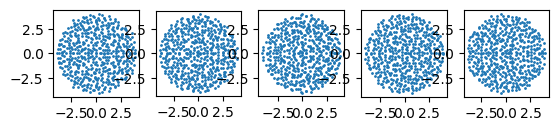

In [5]:
# plot spectra
[fig, subfig_s] = plt.subplots(1, int(connectivity_n))
for connectivity_idx in range(connectivity_n):
  temp_spectrum = jnp.linalg.eig(connectivity_s[connectivity_idx])[0]
  subfig_s[connectivity_idx].plot(jnp.real(temp_spectrum), jnp.imag(temp_spectrum),
                                  linestyle="", marker=".", markersize = 2)
  subfig_s[connectivity_idx].set_aspect('equal')

In [6]:
# initialize and run stats
def short_mean_cov_s_fct(traj):
  return(mean_cov_s_fct(traj[..., (waiting_time * resolution):]))

start_time = time.time()

stat_s_free = mean_cov_s_initializer(condition_n_s_free, part_n)
stat_s_free = stat_s_fct(connectivity_s, wave_s[:1], ext_connectivity_s[:1], phase_s[:1], init_condition_s,
                         labeled_time_interval_s_free, resolution,
                         short_mean_cov_s_fct, stat_s_free)
np.savez_compressed(subdirectory + "stats_free.npz", *stat_s_free) # jax has not implemented savez_compressed as of 23/08/23

stat_s = mean_cov_s_initializer(condition_n_s, part_n)
stat_s = stat_s_fct(connectivity_s, wave_s, ext_connectivity_s, phase_s, init_condition_s[::ext_condition_n],
                    labeled_time_interval_s, resolution, 
                    short_mean_cov_s_fct, stat_s)
np.savez_compressed(subdirectory + "stats.npz", *stat_s)

end_time = time.time()
print("took {:.2f} mins".format((end_time - start_time) / 60))

[5, 'connectivity_n']
[1, 'wave_n']
[1, 'ext_connectivity_n']
[1, 'phase_n']
[160, 'init_condition_n']
2 stats
expecting 17.67 mins
[5, 'connectivity_n']
[5, 'wave_n']
[16, 'ext_connectivity_n']
[2, 'phase_n']
[5, 'init_condition_n']
2 stats
expecting 106.67 mins
took 112.50 mins


In [15]:
# load stats
stat_s_free = load_as_list(subdirectory + "stats_free.npz")
stat_s = load_as_list(subdirectory + "stats.npz")

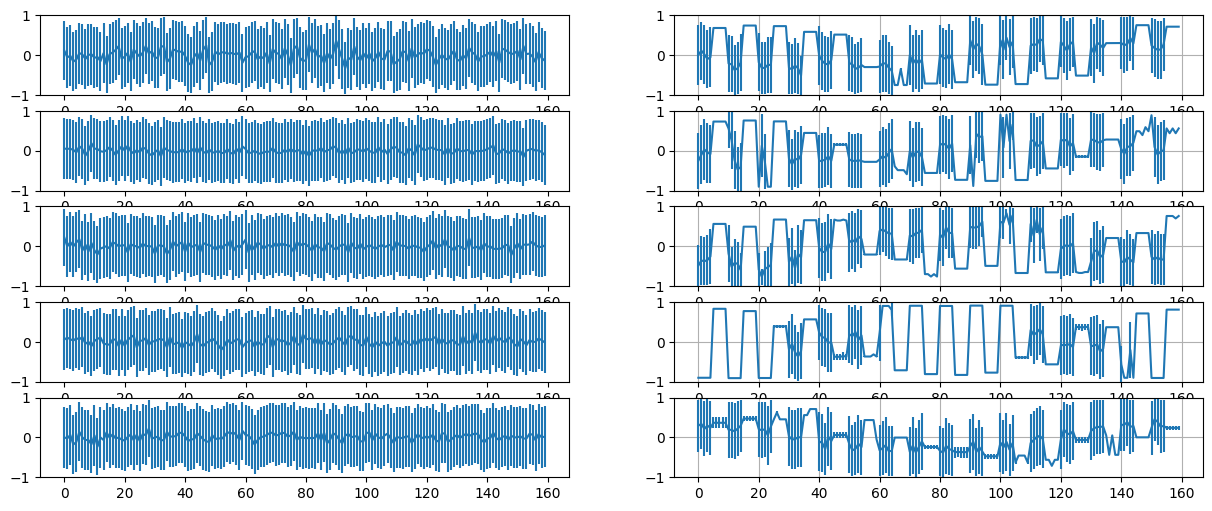

In [16]:
# verify mean std
[fig, subfig_s] = plt.subplots(int(connectivity_n), 2, figsize = (15,6))
for connectivity_idx in range(connectivity_n):
  subfig_s[connectivity_idx,0].errorbar(jnp.arange(init_condition_n_free), 
                                      jnp.mean(stat_s_free[0][connectivity_idx,0,0,0], axis = -1),
                                      yerr=jnp.mean(jnp.diagonal(stat_s_free[1][connectivity_idx,0,0,0], 
                                                            axis1=-1, axis2=-2), axis = -1))
  subfig_s[connectivity_idx,0].set_ylim(-1,1)
  subfig_s[connectivity_idx,0].grid
for connectivity_idx in range(connectivity_n):
  subfig_s[connectivity_idx,1].errorbar(jnp.arange(init_condition_n_free), 
                                      jnp.mean(stat_s[0][connectivity_idx, -1], axis = -1).flatten(),
                                      yerr=jnp.mean(jnp.diagonal(stat_s[1][connectivity_idx, -1], 
                                                            axis1=-1, axis2=-2), axis = -1).flatten())
  subfig_s[connectivity_idx,1].set_ylim(-1,1)
  subfig_s[connectivity_idx,1].grid()

principal components, participation ratios & traces, orientation similarities

In [17]:
start_time = time.time()

#pc
pc_s_free = es_s_fct(stat_s_free[1])
pc_s = es_s_fct(stat_s[1])
#pr
pr_s_free = dim_r_s_fct(pc_s_free[0])
pr_s = dim_r_s_fct(pc_s[0])
np.savez_compressed(subdirectory + "prs.npz", 
                    pr_s_free, pr_s)
#tr
tr_s_free = size_s_fct(pc_s_free[0])
tr_s = size_s_fct(pc_s[0])
np.savez_compressed(subdirectory + "trs.npz", 
                    tr_s_free, tr_s)
# os: vary with angle
os_s_same_all = [
  jnp.asarray(
    ori_similarity_s_fct(pc_s, [jnp.roll(pc_s[idx], angle_idx, axis = 2) for idx in range(2)], 
                         tr_s, jnp.roll(tr_s, angle_idx, axis = 2)))
  for angle_idx in range(unique_angle_n)]
os_s_diff_init = [
  jnp.asarray(
    [ori_similarity_s_fct(pc_s, [jnp.roll(jnp.roll(pc_s[idx], init_condition_idx, axis = 4), 
                                          angle_idx, axis = 2) for idx in range(2)], 
                          tr_s, jnp.roll(jnp.roll(tr_s, init_condition_idx, axis = 4), 
                                         angle_idx, axis = 2))
     for init_condition_idx in range(1, jnp.floor(init_condition_n / 2 + 1).astype(int))])
  for angle_idx in range(unique_angle_n)]
os_s_diff_phase = [
  jnp.asarray(
    [ori_similarity_s_fct(pc_s, [jnp.roll(jnp.roll(pc_s[idx], phase_idx, axis = 3),
                                          angle_idx, axis = 2) for idx in range(2)], 
                          tr_s, jnp.roll(jnp.roll(tr_s, phase_idx, axis = 3),
                                         angle_idx, axis = 2))
     for phase_idx in range(1, jnp.floor(phase_n / 2 + 1).astype(int))])
  for angle_idx in range(unique_angle_n)]
os_s_diff_sys = [
  jnp.asarray(
    [ori_similarity_s_fct(pc_s, [jnp.roll(jnp.roll(pc_s[idx], connectivity_idx, axis = 0),
                                          angle_idx, axis = 2) for idx in range(2)], 
                          tr_s, jnp.roll(jnp.roll(tr_s, connectivity_idx, axis = 0),
                                         angle_idx, axis = 2))
     for connectivity_idx in range(1, jnp.floor(connectivity_n / 2 + 1).astype(int))])
  for angle_idx in range(unique_angle_n)]
np.savez_compressed(subdirectory + "oss.npz", 
                    os_s_same_all, os_s_diff_init, os_s_diff_phase, os_s_diff_sys)
# os: free as baseline
os_s_same_all_free = jnp.asarray(1)
os_s_diff_init_free = jnp.asarray(
  [ori_similarity_s_fct(pc_s_free, [jnp.roll(pc_s_free[idx], init_condition_idx, axis = 4)
                                    for idx in range(2)],
                        tr_s_free, jnp.roll(tr_s_free, init_condition_idx, axis = 4))
   for init_condition_idx in range(1, jnp.floor(init_condition_n_free / 2 + 1).astype(int))])
os_s_diff_phase_free = jnp.asarray(
  [ori_similarity_s_fct(pc_s_free, [jnp.roll(pc_s_free[idx], phase_idx, axis = 3)
                                    for idx in range(2)], 
                        tr_s_free, jnp.roll(tr_s_free, phase_idx, axis = 3))
   for phase_idx in range(1, jnp.floor(phase_n / 2 + 1).astype(int))])
os_s_diff_sys_free = jnp.asarray(
  [ori_similarity_s_fct(pc_s_free, [jnp.roll(pc_s_free[idx], connectivity_idx, axis = 0)
                                    for idx in range(2)], 
                        tr_s_free, jnp.roll(tr_s_free, connectivity_idx, axis = 0))
   for connectivity_idx in range(1, jnp.floor(connectivity_n / 2 + 1).astype(int))])
np.savez_compressed(subdirectory + "oss_free.npz", 
                    os_s_same_all_free, os_s_diff_init_free, os_s_diff_phase_free, os_s_diff_sys_free)

end_time = time.time()
print("took {:.2f} mins".format((end_time - start_time) / 60))

took 7.80 mins


In [18]:
[pr_s_free, pr_s] = load_as_list(subdirectory + "prs.npz")
[tr_s_free, tr_s] = load_as_list(subdirectory + "trs.npz")
[os_s_same_all, os_s_diff_init, os_s_diff_phase, os_s_diff_sys
] = load_as_list(subdirectory + "oss.npz")
[os_s_same_all_free, os_s_diff_init_free, os_s_diff_phase_free, os_s_diff_sys_free
] = load_as_list(subdirectory + "oss_free.npz")

[0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0]

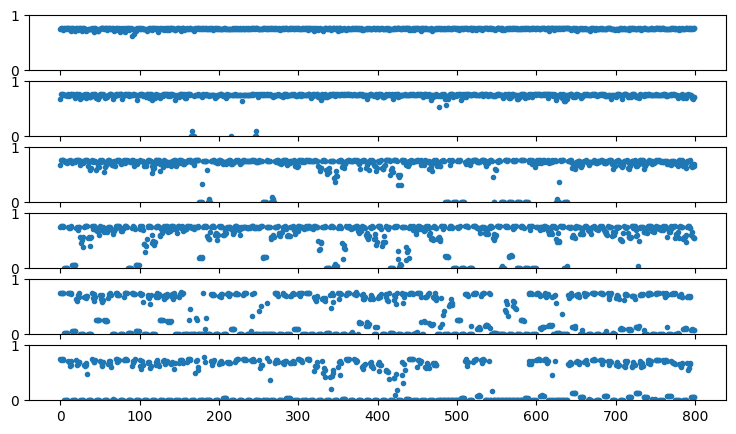

In [19]:
#making sure nothing is strange from the trs
[fig, subfig_s] = plt.subplots(wave_n + 1, 1, figsize = (9, 5))
subfig_s[0].plot(tr_s_free.flatten(), label = 0., 
                 marker='.', linestyle='')
for wave_idx in range(wave_n):
  subfig_s[wave_idx + 1].plot(tr_s[:, wave_idx].flatten(), label = amp_s[wave_idx, 0],
                              marker='.', linestyle='')
plt.setp(subfig_s, ylim=(0,1))

Text(0, 0.5, 'trace')

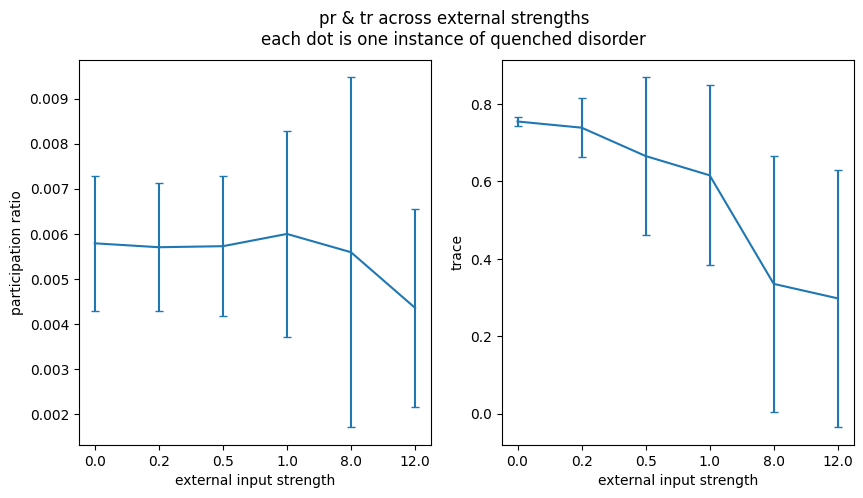

In [20]:
amp_s_all = jnp.insert(amp_s.flatten(), 0, 0)
amp_n_all = amp_s_all.shape[0]
ea_stat_s_all_wrt_amp = [[jnp.concatenate([fct(quant_pair[0], axis = (4, 2, 3, 0)),
                                           fct(quant_pair[1], axis = (4, 2, 3, 0))]) 
                          for fct in [jnp.mean, jnp.std]] 
                         for quant_pair in [[pr_s_free, pr_s], [tr_s_free, tr_s]]]

[fig, subfig_s] = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle("pr & tr across external strengths"
             + "\neach dot is one instance of quenched disorder")
for quant_idx in range(2):
  subfig_s[quant_idx].errorbar(jnp.arange(amp_n_all), ea_stat_s_all_wrt_amp[quant_idx][0],
                               yerr = ea_stat_s_all_wrt_amp[quant_idx][1],
                               capsize = 3)
  subfig_s[quant_idx].set_xticks(jnp.arange(amp_n_all), labels = amp_s_all)
  subfig_s[quant_idx].set_xlabel("external input strength")
subfig_s[0].set_ylabel("participation ratio")
subfig_s[1].set_ylabel("trace")

(0.0, 1.1)

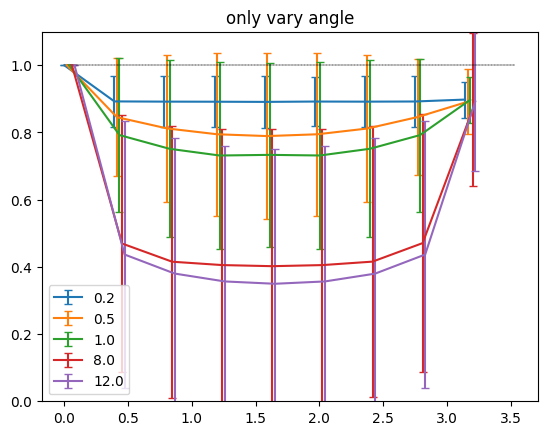

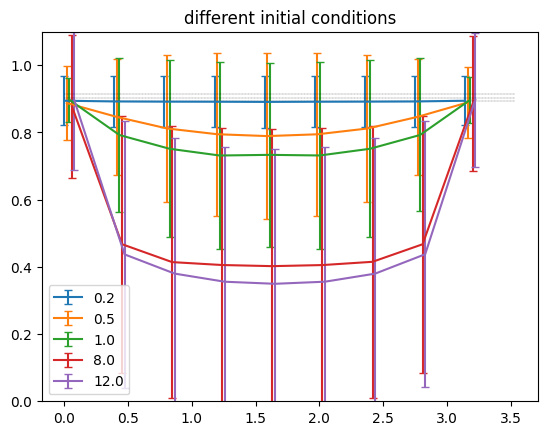

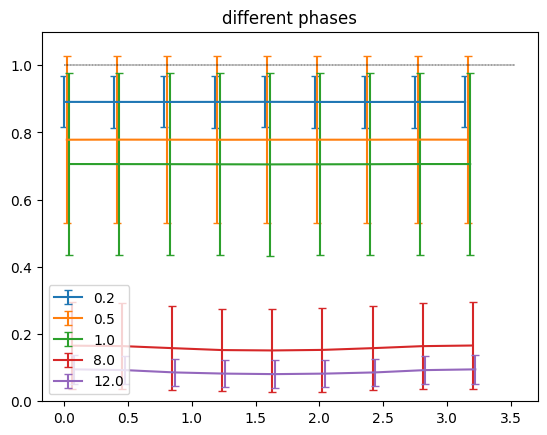

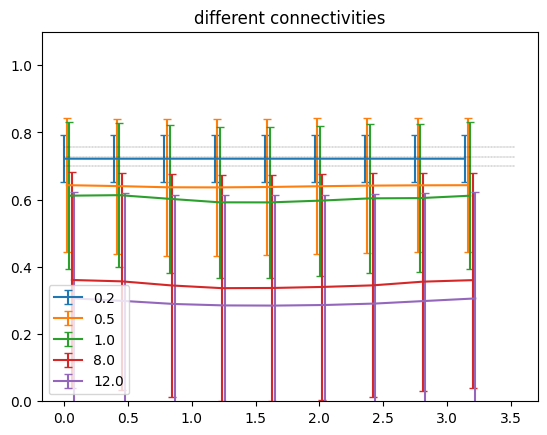

In [21]:
# only vary angle
[ymin, ymax] = [0,1.1]

plt.figure()
plt.title("only vary angle")
for wave_idx in range(wave_n):
  plt.errorbar(angle_s[:unique_angle_n] + wave_idx/50, 
               [jnp.mean(os_s_same_all[angle_idx][:, wave_idx]) for angle_idx in range(unique_angle_n)],
               yerr = [jnp.std(os_s_same_all[angle_idx][:, wave_idx]) for angle_idx in range(unique_angle_n)],
               capsize = 3, label = str(amp_s[wave_idx, 0]))
plt.legend(loc = 'lower left')
plt.hlines(jnp.mean(os_s_same_all_free) + jnp.asarray([-1,0,1]) * jnp.std(os_s_same_all_free),
           angle_s[0], angle_s[unique_angle_n],
           linestyle='--', color='k', linewidth=0.2)
plt.ylim(ymin, ymax)

# different initial conditions
plt.figure()
plt.title("different initial conditions")
for wave_idx in range(wave_n):
  plt.errorbar(angle_s[:unique_angle_n] + wave_idx/50, 
               [jnp.mean(os_s_diff_init[angle_idx][:, :, wave_idx]) for angle_idx in range(unique_angle_n)],
               yerr = [jnp.std(os_s_diff_init[angle_idx][:, :, wave_idx]) for angle_idx in range(unique_angle_n)],
               capsize = 3, label = str(amp_s[wave_idx, 0]))
plt.legend(loc = 'lower left')
plt.hlines(jnp.mean(os_s_diff_init_free) + jnp.asarray([-1,0,1]) * jnp.std(os_s_diff_init_free), 
           angle_s[0], angle_s[unique_angle_n],
           linestyle='--', color='k', linewidth=0.2)
plt.ylim(ymin, ymax)

# different phases
plt.figure()
plt.title("different phases")
for wave_idx in range(wave_n):
  plt.errorbar(angle_s[:unique_angle_n] + wave_idx/50, 
               [jnp.mean(os_s_diff_phase[angle_idx][:, :, wave_idx]) for angle_idx in range(unique_angle_n)],
               yerr = [jnp.std(os_s_diff_phase[angle_idx][:, :, wave_idx]) for angle_idx in range(unique_angle_n)],
               capsize = 3, label = str(amp_s[wave_idx, 0]))
plt.legend(loc = 'lower left')
plt.hlines(jnp.mean(os_s_diff_phase_free) + jnp.asarray([-1,0,1]) * jnp.std(os_s_diff_phase_free), 
           angle_s[0], angle_s[unique_angle_n],
           linestyle='--', color='k', linewidth=0.2)
plt.ylim(ymin, ymax)

# different connectivities
plt.figure()
plt.title("different connectivities")
for wave_idx in range(wave_n):
  plt.errorbar(angle_s[:unique_angle_n] + wave_idx/50, 
               [jnp.mean(os_s_diff_sys[angle_idx][:, :, wave_idx]) for angle_idx in range(unique_angle_n)],
               yerr = [jnp.std(os_s_diff_sys[angle_idx][:, :, wave_idx]) for angle_idx in range(unique_angle_n)],
               capsize = 3, label = str(amp_s[wave_idx, 0]))
plt.legend(loc = 'lower left')
plt.hlines(jnp.mean(os_s_diff_sys_free) + jnp.asarray([-1,0,1]) * jnp.std(os_s_diff_sys_free), 
           angle_s[0], angle_s[unique_angle_n],
           linestyle='--', color='k', linewidth=0.2)
plt.ylim(ymin, ymax)

nonzero mean, do mean stats

In [24]:
mean_rms_s = jnp.sqrt(jnp.mean(stat_s[0] ** 2, axis = -1))
mean_rms_s_free = jnp.sqrt(jnp.mean(stat_s_free[0] ** 2, axis = -1))

def vector_ori_similarity_s_fct(vector_s_1, vector_s_2, std_s_1, std_s_2):
  part_n = vector_s_1.shape[-1]
  return(jnp.einsum("...i, ...i -> ...", vector_s_1, vector_s_2)
         / std_s_1 / std_s_2 / part_n)

# os: vary with angle
mean_os_s_same_all = [
  jnp.asarray(
    vector_ori_similarity_s_fct(
      stat_s[0], jnp.roll(stat_s[0], angle_idx, axis = 2),
      mean_rms_s, jnp.roll(mean_rms_s, angle_idx, axis = 2)))
  for angle_idx in range(unique_angle_n)]
mean_os_s_diff_init = [
  jnp.asarray(
    [vector_ori_similarity_s_fct(
      stat_s[0], jnp.roll(jnp.roll(stat_s[0], init_condition_idx, axis = 4), 
                           angle_idx, axis = 2), 
      mean_rms_s, jnp.roll(jnp.roll(mean_rms_s, init_condition_idx, axis = 4), 
                           angle_idx, axis = 2))
     for init_condition_idx in range(1, jnp.floor(init_condition_n / 2 + 1).astype(int))])
  for angle_idx in range(unique_angle_n)]
mean_os_s_diff_phase = [
  jnp.asarray(
    [vector_ori_similarity_s_fct(
      stat_s[0], jnp.roll(jnp.roll(stat_s[0], phase_idx, axis = 3),
                           angle_idx, axis = 2), 
      mean_rms_s, jnp.roll(jnp.roll(mean_rms_s, phase_idx, axis = 3),
                           angle_idx, axis = 2))
     for phase_idx in range(1, jnp.floor(phase_n / 2 + 1).astype(int))])
  for angle_idx in range(unique_angle_n)]
mean_os_s_diff_sys = [
  jnp.asarray(
    [vector_ori_similarity_s_fct(
      stat_s[0], jnp.roll(jnp.roll(stat_s[0], connectivity_idx, axis = 0),
                           angle_idx, axis = 2), 
      mean_rms_s, jnp.roll(jnp.roll(mean_rms_s, connectivity_idx, axis = 0),
                           angle_idx, axis = 2))
     for connectivity_idx in range(1, jnp.floor(connectivity_n / 2 + 1).astype(int))])
  for angle_idx in range(unique_angle_n)]
# os: free cannot be used as baseline: all 0s

(-2.0, 2.0)

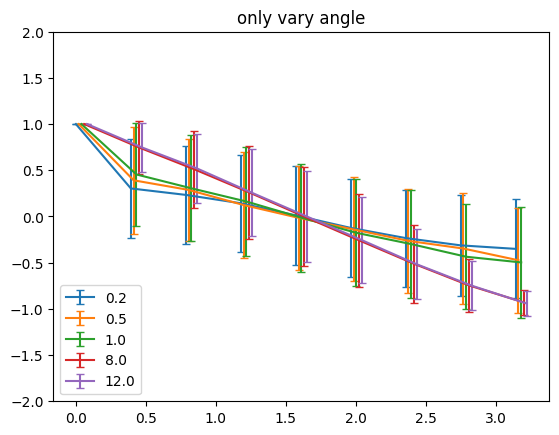

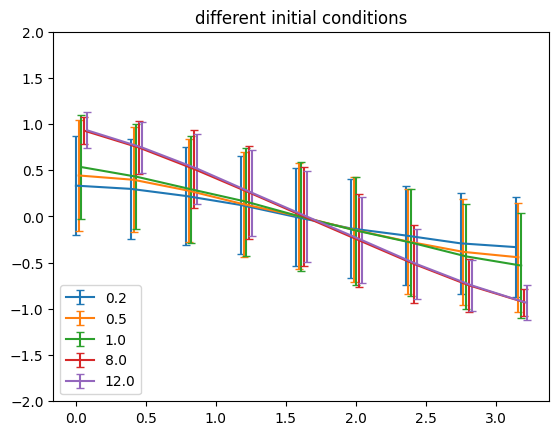

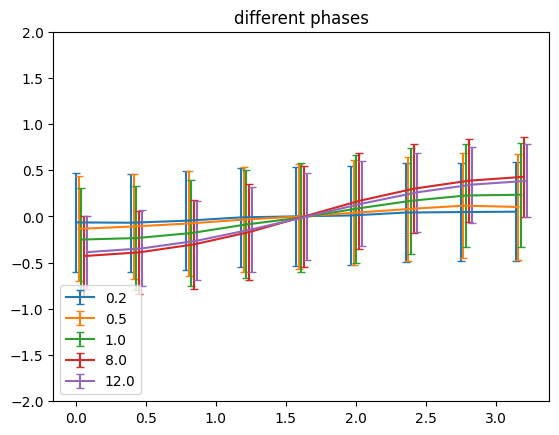

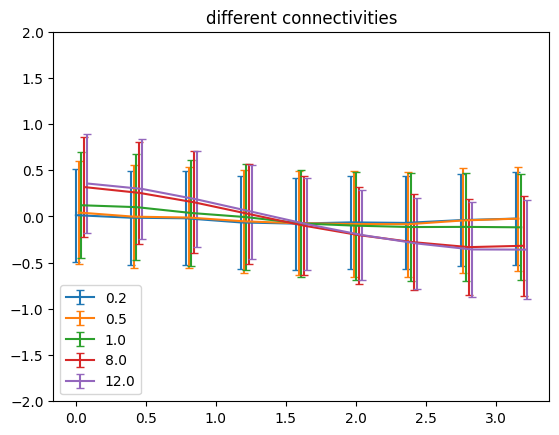

In [25]:
# only vary angle
[ymin, ymax] = [-2,2]

plt.figure()
plt.title("only vary angle")
for wave_idx in range(wave_n):
  plt.errorbar(angle_s[:unique_angle_n] + wave_idx/50, 
               [jnp.mean(mean_os_s_same_all[angle_idx][:, wave_idx]) for angle_idx in range(unique_angle_n)],
               yerr = [jnp.std(mean_os_s_same_all[angle_idx][:, wave_idx]) for angle_idx in range(unique_angle_n)],
               capsize = 3, label = str(amp_s[wave_idx, 0]))
plt.legend(loc = 'lower left')
plt.ylim(ymin, ymax)

# different initial conditions
plt.figure()
plt.title("different initial conditions")
for wave_idx in range(wave_n):
  plt.errorbar(angle_s[:unique_angle_n] + wave_idx/50, 
               [jnp.mean(mean_os_s_diff_init[angle_idx][:, :, wave_idx]) for angle_idx in range(unique_angle_n)],
               yerr = [jnp.std(mean_os_s_diff_init[angle_idx][:, :, wave_idx]) for angle_idx in range(unique_angle_n)],
               capsize = 3, label = str(amp_s[wave_idx, 0]))
plt.legend(loc = 'lower left')
plt.ylim(ymin, ymax)

# different phases
plt.figure()
plt.title("different phases")
for wave_idx in range(wave_n):
  plt.errorbar(angle_s[:unique_angle_n] + wave_idx/50, 
               [jnp.mean(mean_os_s_diff_phase[angle_idx][:, :, wave_idx]) for angle_idx in range(unique_angle_n)],
               yerr = [jnp.std(mean_os_s_diff_phase[angle_idx][:, :, wave_idx]) for angle_idx in range(unique_angle_n)],
               capsize = 3, label = str(amp_s[wave_idx, 0]))
plt.legend(loc = 'lower left')
plt.ylim(ymin, ymax)

# different connectivities
plt.figure()
plt.title("different connectivities")
for wave_idx in range(wave_n):
  plt.errorbar(angle_s[:unique_angle_n] + wave_idx/50, 
               [jnp.mean(mean_os_s_diff_sys[angle_idx][:, :, wave_idx]) for angle_idx in range(unique_angle_n)],
               yerr = [jnp.std(mean_os_s_diff_sys[angle_idx][:, :, wave_idx]) for angle_idx in range(unique_angle_n)],
               capsize = 3, label = str(amp_s[wave_idx, 0]))
plt.legend(loc = 'lower left')
plt.ylim(ymin, ymax)

In [9]:
phase_s

array([[0.25356042],
       [0.8236704 ]], dtype=float32)